---
*** THE SECOND PART OF BLACKJACK***

---
Pretrained model is loaded and trained with smaller learning rate. Some parts of code are simmilar than in part one. Training is significantly faster and there is no huge changes during in decision making process to achieve delcared reward.

After obtaining satisfying results, the final decision plot is generated and win ratio is calculated.


In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Blackjack-v1')  # Create the environment
env.reset()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


(19, 1, True)

Loading pretrained model. File to load was attached to mail with project and it is in the github repository.

In [24]:
model = keras.models.load_model("model_Black_jack.h5")

Learning rate was set as 0.005

Function res is created to return probability of "pass" action when playr's and dealer's card are known.

In [25]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

gamma=0.9
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

num_inputs = 3    # 3 parameters describing the state
num_actions = 2 

X=[]
Y=[]
i=0
def res(x,y):
    stan=[x,y,0]
    stan = tf.convert_to_tensor(stan)
    stan = tf.expand_dims(stan, 0)
    probs,ac=model(stan)
    return float(probs[0][0])

running reward: 0.08 at episode 500
1.0
0.03
running reward: 0.04 at episode 1000
0.98
0.02
Solved at episode 1473!


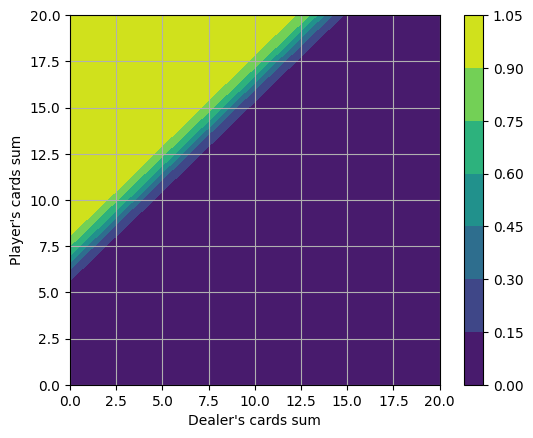

In [27]:
while True:  # Run until solved
    state = env.reset()

    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, 3):
            
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)


            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value)


            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            
            #print(state)
            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            #print(action,state, reward, done)
            
            if done:

                break

        # Update running reward to check condition for solving
        running_reward = 0.1 * episode_reward + (1 - 0.1) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 500 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))
        stan=[19,10,0]
        stan = tf.convert_to_tensor(stan)
        stan = tf.expand_dims(stan, 0)
        probs,ac=model(stan)
        print(round(float(probs[0][0]),2))
        stan=[10,9,0]
        stan = tf.convert_to_tensor(stan)
        stan = tf.expand_dims(stan, 0)
        probs,ac=model(stan)
        print(round(float(probs[0][0]),2))

    if running_reward > 0.55:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        Z=[]
        X=np.linspace(0,20,21)
        Y=np.linspace(0,20,21)
        XY=np.meshgrid(X,Y,sparse=True)
        Z=np.zeros((21,21))

        for x in X:
          for y in Y:
            x=int(x); y=int(y)
            Z[x][y]=res(x,y)

        plt.contourf(X, Y, Z)

        plt.axis('scaled')
        plt.xlabel("Dealer's cards sum")
        plt.ylabel("Player's cards sum")
        #plt.clim(0,1)
        plt.grid()
        plt.colorbar(boundaries=[0,0.5,1])

        plt.show()
        break

In [22]:
stan=[1,14,0]
stan = tf.convert_to_tensor(stan)
stan = tf.expand_dims(stan, 0)
probs,ac=model(stan)
print(float(probs[0][0]))
model.save('model_Black_jack1.h5')

0.012409565038979053


**Results**

Decision chart shows probability of PASS action as function sum of dealer's and sum of players's cards. We can see th player would pass when he has higher sum and play when he has lower sum. Boundaries between pass and play region are sharp what we can understand as most of decisions are well-defined.

The win ratio was calculated approximatelly 40% what is impresive because the best strategy (mathematicaly proved) gives win ratio 42% and this NN has no knowledge about the game and was learning only by playing.

In [28]:
#sprawdz, porownaj

games=1e4
player_win=0
dealer_win=0
game=0

while game<games:
    state = env.reset()
    for timestep in range(1, 4):
          state = tf.convert_to_tensor(state)
          state = tf.expand_dims(state, 0)
          probability, b = model(state)
          if float(probability[0][0])>float(probability[0][1]):
              action=0;
          else:
              action=1
          state, reward, done, _ = env.step(action)

          if done:
              break
    if reward>0:
        player_win+=1
    elif reward<0:
          dealer_win+=1
    game+=1


print(player_win/games)
print(dealer_win/games)


0.3954
0.5094
